# 3-Layer Neural Network for Non-linear Regression (TensorFlow Functional API)
In this notebook, we implement a 3-layer neural network using TensorFlow’s Functional API, which offers greater flexibility compared to the Sequential API—allowing for more complex architectures while still providing high-level abstractions.

We’ll also leverage TensorFlow’s built-in training and evaluation utilities to streamline model development.

To ensure consistency and enable fair comparison across implementations, we'll continue using the same synthetic 3-variable non-linear dataset used previously.

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the function to generate synthetic data
def true_function(X):
    """
    Non-linear function with 3 variables
    X should be a matrix with 3 columns
    """
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# Generate synthetic dataset
def generate_data(n_samples=1000):
    # Generate random inputs
    X = tf.cast(tf.random.uniform((n_samples, 3), -2, 2), tf.float32)

    # Calculate true output values
    y_true = true_function(X)

    # Add some noise
    y = y_true + tf.random.normal((n_samples,), 0, 0.5)

    return X, tf.reshape(y, (-1, 1))

# Generate training data
X_train, y_train = generate_data(1000)

# Generate test data
X_test, y_test = generate_data(200)

print(f"Training data shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test data shape: X = {X_test.shape}, y = {y_test.shape}")

Training data shape: X = (1000, 3), y = (1000, 1)
Test data shape: X = (200, 3), y = (200, 1)


## Neural Network Implementation with TensorFlow Functional API
In this section, we’ll define our 3-layer neural network using TensorFlow’s Functional API, which enables more flexibility compared to the Sequential API—especially useful for designing custom or branched architectures.

Despite the flexible structure, we’ll still benefit from TensorFlow’s high-level utilities for training, loss computation, and evaluation, streamlining the model development process.

In [2]:
# Create model using Functional API
def create_functional_model(input_size, hidden1_size, hidden2_size, output_size):
    # Define input layer
    inputs = tf.keras.Input(shape=(input_size,))

    # First hidden layer with ReLU activation
    x = tf.keras.layers.Dense(
        hidden1_size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(inputs)

    # Second hidden layer with ReLU activation
    x = tf.keras.layers.Dense(
        hidden2_size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(x)

    # Output layer (no activation for regression)
    outputs = tf.keras.layers.Dense(
        output_size,
        activation=None,
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="NonlinearRegression")

    return model

# Create model instance
input_size = 3
hidden1_size = 10
hidden2_size = 5
output_size = 1

model = create_functional_model(input_size, hidden1_size, hidden2_size, output_size)
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error as additional metric
)

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64)

# Create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Define callbacks for monitoring training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=0.0001
    )
]

# Train the model
start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=3000,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

Model: "NonlinearRegression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 9.1927 - mae: 2.5101 - val_loss: 6.7382 - val_mae: 2.1471 - learning_rate: 0.0050
Epoch 2/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0185 - mae: 2.0568 - val_loss: 4.8434 - val_mae: 1.8362 - learning_rate: 0.0050
Epoch 3/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1906 - mae: 1.6963 - val_loss: 3.1465 - val_mae: 1.4803 - learning_rate: 0.0050
Epoch 4/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5817 - mae: 1.3082 - val_loss: 1.8371 - val_mae: 1.1299 - learning_rate: 0.0050
Epoch 5/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5510 - mae: 1.0230 - val_loss: 1.3594 - val_mae: 0.9455 - learning_rate: 0.0050
Epoch 6/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2948 - mae: 0.9165 - val_loss: 1.0457 - val_mae: 0.8245 - learning_rate: 0.0050
Epoch 7/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9968 - mae: 0.8027 - val_loss: 0.8763 - val_mae: 0.7496 - learning_rate: 0.0050
Epoch

## Model Evaluation and Visualization
With our model built using TensorFlow’s Functional API, we’ll now evaluate its performance on the test dataset.
We'll also visualize key aspects of the model’s behavior, including:

The training loss curve to assess learning dynamics

Predicted vs. actual values to evaluate model accuracy

Visual insights into how well the model has captured the non-linear relationships in the data

These visualizations help validate the model’s effectiveness and guide further tuning if needed.

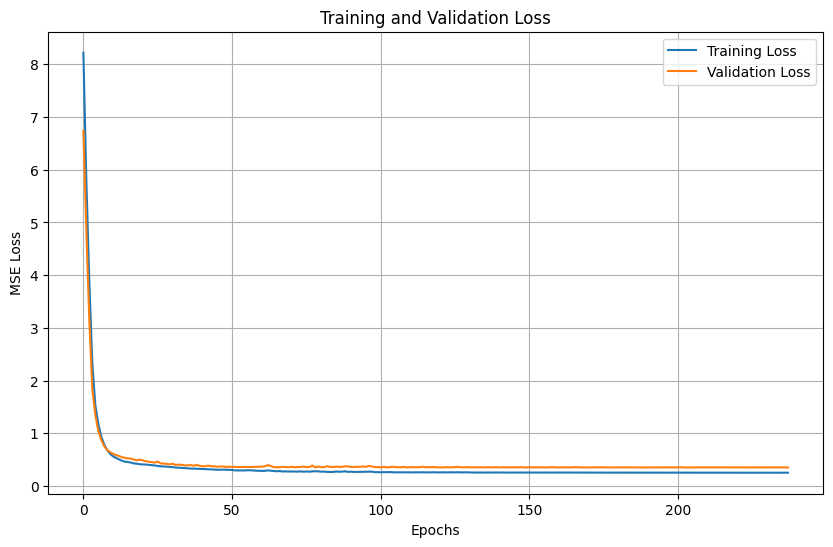

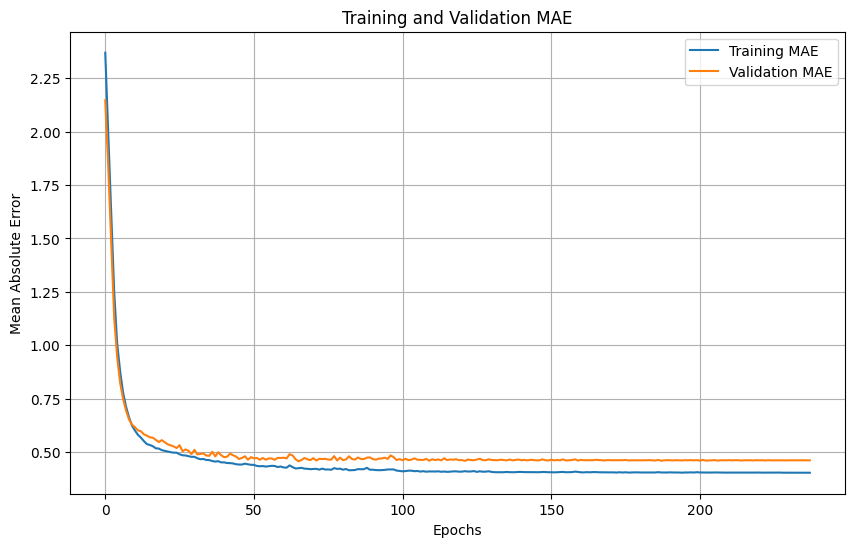

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3122 - mae: 0.4332 
Test Loss (MSE): 0.351544
Test MAE: 0.459174
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


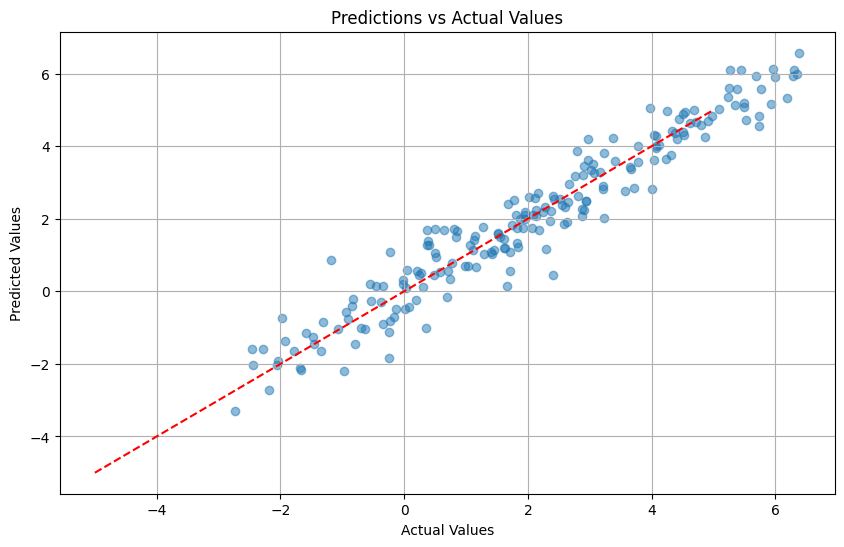

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


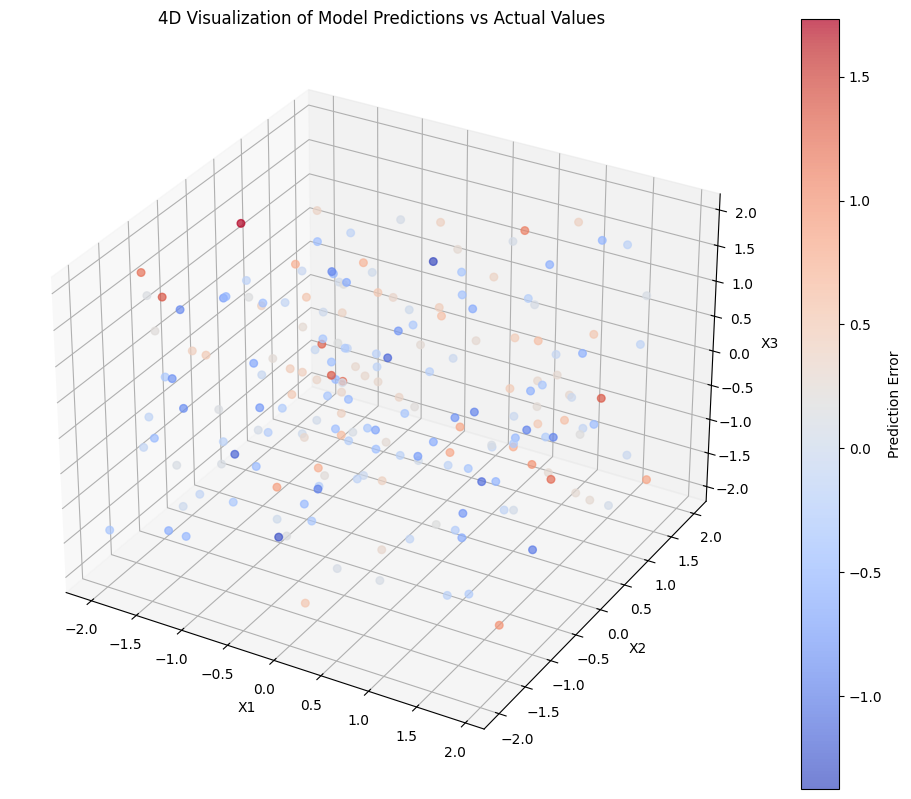

In [3]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE metric
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_results[0]:.6f}")
print(f"Test MAE: {test_results[1]:.6f}")

# Get predictions
y_pred_test = model.predict(X_test)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test, alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Create a 4D visualization (3D plot with color as the 4th dimension)
def visualize_4d(X, y_true, y_pred, title):
    # Convert tensors to numpy
    X_np = X.numpy()
    y_true_np = y_true.numpy().flatten()
    y_pred_np = y_pred.flatten()

    # Create a 3D scatter plot with color as the 4th dimension
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate prediction error for coloring
    error = y_true_np - y_pred_np

    # Create the scatter plot
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error,  # Use error for coloring
                          cmap=cm.coolwarm,
                          marker='o',
                          alpha=0.7,
                          s=30)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)

    # Show the plot
    plt.show()

# Generate sample data points for visualization
X_vis, y_vis = generate_data(200)

# Get predictions for visualization
y_vis_pred = model.predict(X_vis)

# Create 4D visualization
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Model Predictions vs Actual Values')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


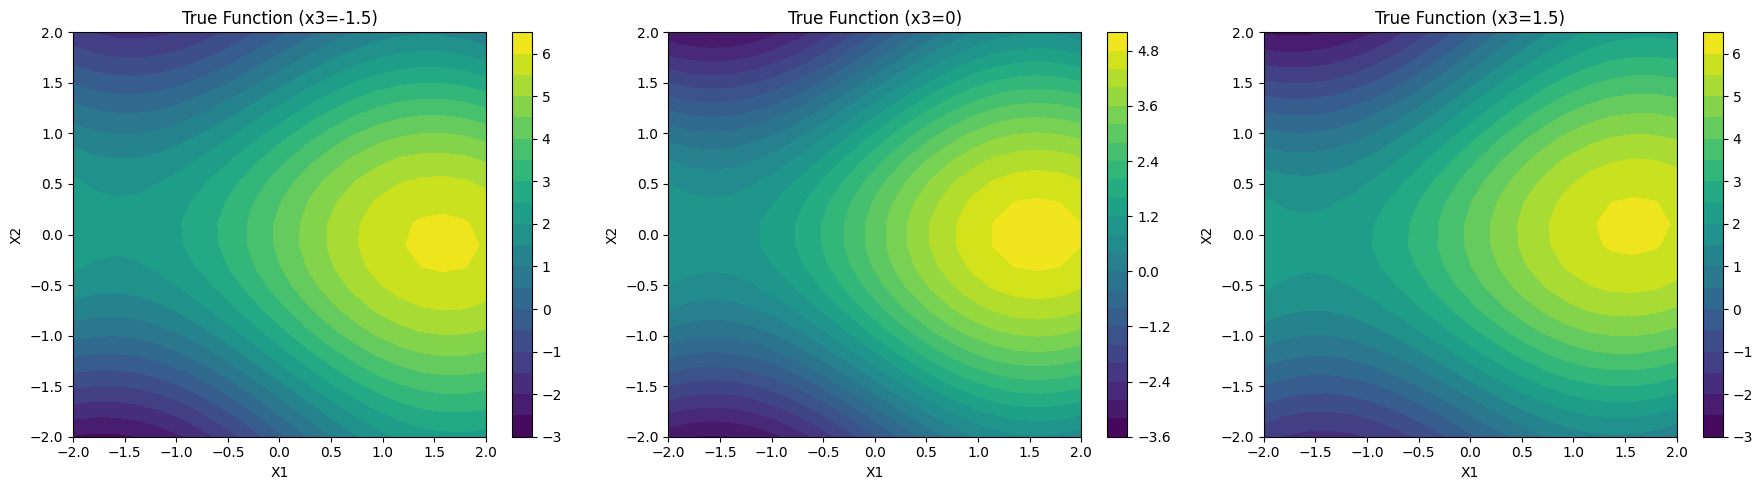

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


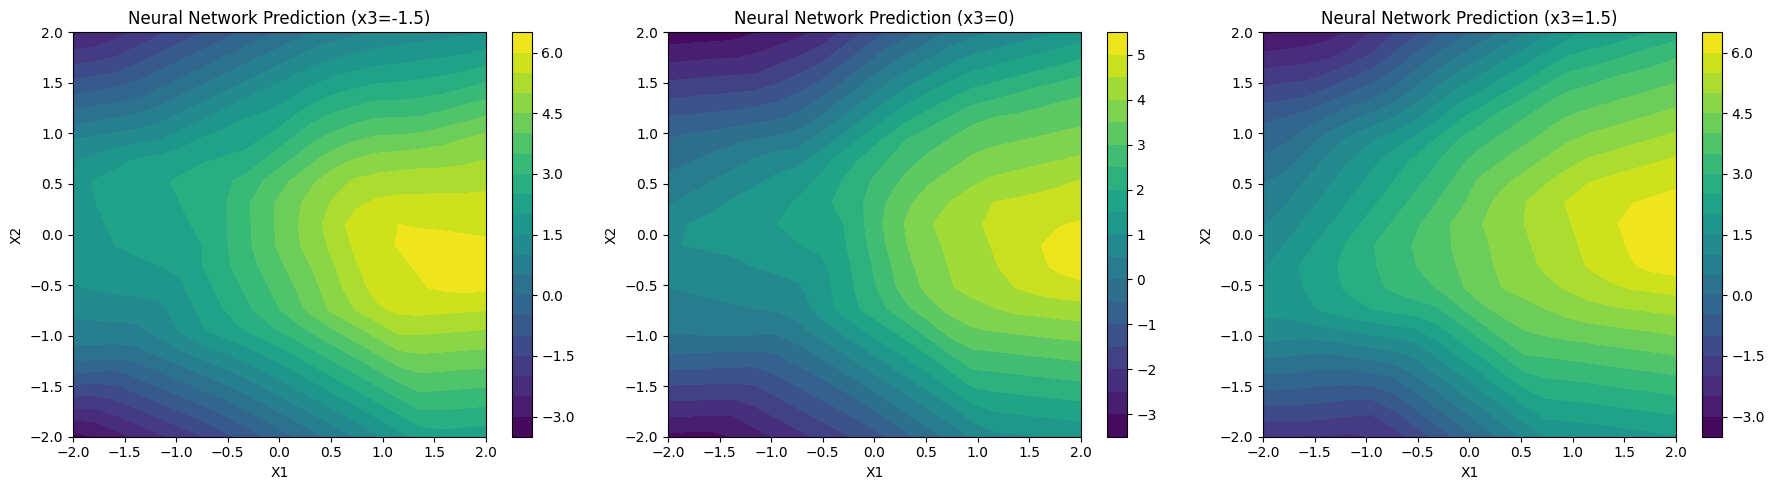

In [4]:
# Alternative visualization with 2D slices
def plot_2d_slices(X_range=2.0, grid_points=20):
    # Create a grid of points for visualization
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]  # Three fixed values for x3

    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model.predict(X_input).reshape(grid_points, grid_points)

        # Plot the true function
        im1 = axes[i].contourf(X1, X2, y_true, cmap='viridis', levels=20)
        axes[i].set_title(f'True Function (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im1, ax=axes[i])

    plt.tight_layout()
    plt.show()

    # Now plot the predicted function
    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model.predict(X_input).reshape(grid_points, grid_points)

        # Plot the predicted function
        im2 = axes[i].contourf(X1, X2, y_pred, cmap='viridis', levels=20)
        axes[i].set_title(f'Neural Network Prediction (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im2, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Generate and plot 2D slices
plot_2d_slices(X_range=2.0, grid_points=20)